# Data Preparation

Data description include source, size, type, attributes, modality, etc. 
Data retrieval from community data centers, personal cloud storage, or published datasets. 
Feature extraction and engineering.

Model training data uses data from the following sources National Resource Conservation Service (NRCS) Snow Telemetry (SNOTEL), California Data Exchange Center (CDEC), Copernicus 90-m DEM, and the NASA Airborne Snow Observatory (ASO).
In addition to these data sources, we create feature based upon the water year weak, latitude, longitude, and elevation.
From these data sources we created the following features for input into the machine learning models.

|Feature id| Description|
 |:-----------: | :--------: |
 |WY Week | Numerical ID of the week of the water year|
 |Latitude | Center latitude of the training grid cell |
 |Longitude | Center longitude of the training grid cell|
 |Elevation | DEM elevation of the training grid cell |
 |Northness | Calculated northness of the training cell|
 |SNOTEL SWE | Current week's observed SWE from SNOTEL|
 |Prev SNOTEL SWE | Previous week's observed SWE from SNOTEL|
 |Delta SNOTEL SWE | Difference between Previous week's and current week's observed SWE from SNOTEL|
 |Previous SWE | Observed SWE from previous week|
 
 *Note, the Previous SWE feature is an observation for model training and testing but will be predicted when forecating.*
 
 ## SNOTEL and CDEC Snow Monitoring Data
 
 <img align = 'right' src="Images/SNOTEL.jpg" alt = 'drawing' width = '400'/>
SNOTEL is an automated system of snowpack and related climate sensors operated by the Natural Resources Conservation Service (NRCS) that record key snow and hydrometeorological components and transmit observations via a telemetry netrwork. 
There are over 600 SNOTEL sites distributed accross the western US and Alaska, and have become standard climate information to understand snowpack dynamics and estimate water supply. 
Standard SNOTEL sites include a pressure sensing snow pillow to measure SWE based on hydrostatic pressure created by overlying snow, snow depth, storage precipitation gauge, and air temperature sensor.  
System data-loggers provide functions for computing daily maximum, minimum, and average temperature information from data recorded every 15 minutes. 

SNOTEL central computer receives all monitoring station information and transmits to the Centralized Forecasting System (CFS). 
The CFS maintains the data is in a relational database, supporting analysis and graphics programs for data analytics.
The system supports data retreival of current and historical data for analyses.




# Getting Started With Data Processing

Data processing is likley the most tedious part of the model development pipeline. 
Model development leveraged multiple pre-processing and feature engineering steps to prepare the input data for use within the model.
Data pre-processing included the use of elevation, slope, and aspect, derived from DEM data, through nearest-neighbor interpolation to produce values for all training, testing, and inference locations based on the four latitude and longitude corners of each respective grid cell.
We calculated the northness metric based on the slope and aspect values of each grid cell.
The embedded slope and aspect information within the northness metric aids in ML model training and reduces the overall dimensionality.

Feature engineering consisted of the development of temporal features to support model training relative to seasonal snow accumulation and melt phases.
Temporal features include a week-id for every observation and submission as an integer representing the week of the water year (WY) beginning October 1st, corresponding to WY week 1, and the week ending September 31st, corresponding to WY week 52.
We utilized in-situ station SWE observations as features, using the values observed from the current (Snotel/CDEC SWE) and the previous week (Previous Snotel/CDEC SWE) as inputs.
Using the observations from the current and previous week, we calculated the difference to capture the trend, either positive or negative, in SWE dynamics (i.e, melt or accumulation) with respect to each monitoring station ( $\Delta$ SWE).
Because of the serial correlation of snow accumulation and melt on the current timesteps SWE prediction, the model uses the SWE estimate of the previous week as a feature (Previous SWE).
For model training and testing, the Previous SWE input is from NASA ASO datasets.

In [5]:
import pandas as pd
import json 
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pystac_client import Client
import planetary_computer
import rioxarray
from pyproj import Transformer
import h5py
from mpl_toolkits.basemap import Basemap
import math
from tqdm import tqdm
#import geopandas
import richdem as rd
#import elevation
#import hdfdict
import pickle
import random
import copy
import io
from datetime import date, timedelta
import xarray as xr
import requests
#import netCDF4
import tempfile
import os
from platform import python_version
import tables

from matplotlib.axes import Axes
import warnings; warnings.filterwarnings("ignore")

#print(pd.__version__) 
print(python_version()) 

3.7.12


In [6]:
import session_info
session_info.show()

## Loading Provided SWE Observations from Snowcast Showdown

The project supported the participation of the Snowcast Showdown, and while we shared useful code for SNOTEL and CDEC data retrievel (needed for forecasting), the information was provided by the United State Bureau of Reclaimation. 
We provide the supported modeling materials and provide the respective data processing and feature engineering steps.

In [7]:
#Set up training DF with key metadata per site
#All coordinates of 1 km polygon used to develop ave elevation, ave slope, ave aspect

colnames = ['cell_id', 'Region', 'BR_Coord', 'UR_Coord', 'UL_Coord', 'BL_Coord']
SWEdata = pd.DataFrame(columns = colnames, dtype=object)

#Load training SWE data
TrainSWE = pd.read_csv('Provided_Data/Prediction_Location_Observations.csv')
#drop na and put into modeling df format
TrainSWE = TrainSWE.melt(id_vars=["cell_id"]).dropna()

#May or may not need to melt data
#Load Testing SWE locations
TestSWE = pd.read_csv('Provided_Data/submission_format.csv')
#drop na and put into modeling df format
TestSWE = TestSWE.melt(id_vars=["cell_id"]).dropna()

#Load  SWE location data
with open("Provided_Data/grid_cells.geojson") as f:
    data = json.load(f)
    
#load ground truth values(SNOTEL): training
GM_Train = pd.read_csv('Provided_Data/ground_measures_train_features.csv')
#drop na and put into modeling df format
GM_Train = GM_Train.melt(id_vars=["station_id"]).dropna()

#load ground truth values (SNOTEL): Testing
GM_Test = pd.read_csv('Provided_Data/ground_measures_test_features.csv')
#drop na and put into modeling df format
GM_Test = GM_Test.melt(id_vars=["station_id"]).dropna()

#load ground truth meta
GM_Meta = pd.read_csv('Provided_Data/ground_measures_metadata.csv')

#merge training ground truth location metadata with snotel data
GM_Train = GM_Meta.merge(GM_Train, how='inner', on='station_id')
GM_Train = GM_Train.set_index('station_id')
GM_Train.rename(columns={'name': 'location', 'latitude': 'Lat', 'longitude': 'Long', 'value': 'SWE'}, inplace=True)


#merge testing ground truth location metadata with snotel data
GM_Test = GM_Meta.merge(GM_Test, how='inner', on='station_id')
GM_Test = GM_Test.set_index('station_id')
GM_Test.rename(columns={'name': 'location', 'latitude': 'Lat', 'longitude': 'Long', 'value': 'SWE'}, inplace=True)

#Make a SWE Grid location DF
for i in tqdm(range(len(data["features"]))):
    properties = data["features"][i]["properties"]
    location = data["features"][i]["geometry"]
    DFdata = [properties ["cell_id"],  properties ["region"],location ["coordinates"][0][0] ,
             location ["coordinates"][0][1], location ["coordinates"][0][2], location ["coordinates"][0][3] ]
    df_length = len(SWEdata)
    SWEdata.loc[df_length] = DFdata
    
#Make SWE location and observation DF
#Training
#merge site location metadata with observations
TrainSWE = TrainSWE.merge(SWEdata, how='inner', on='cell_id')
TrainSWE = TrainSWE.set_index('cell_id')
TrainSWE.rename(columns={'variable': 'Date', 'value': 'SWE'}, inplace=True)

#Make sure Date is in datetime data type
TrainSWE['Date'] = pd.to_datetime(TrainSWE['Date'])

100%|██████████| 18130/18130 [00:43<00:00, 421.07it/s]


## Selecting the Rockies as a demonstration region for the tutorial

The Snowcast Showdown competition modeling domain is the entire western US.
For the tutorial, we select a subset of the region to reduce the computational burden on the end user which speeds up model development.
We transition the file architecture from csv's to HDF5 to reduce the amount of memory and speed up computations. 
You can read more about using HDF5 files [here](https://www.geeksforgeeks.org/hdf5-files-in-python/)

In [8]:
#Get Lat Long information
#Bottom right coord
TrainSWE[['BR_Coord_Long','BR_Coord_Lat']] = pd.DataFrame(TrainSWE.BR_Coord.tolist(), index= TrainSWE.index)

#Upper right coord
TrainSWE[['UR_Coord_Long','UR_Coord_Lat']] = pd.DataFrame(TrainSWE.UR_Coord.tolist(), index= TrainSWE.index)

#Upper left coord
TrainSWE[['UL_Coord_Long','UL_Coord_Lat']] = pd.DataFrame(TrainSWE.UL_Coord.tolist(), index= TrainSWE.index)

#Bottom Left coord
TrainSWE[['BL_Coord_Long','BL_Coord_Lat']] = pd.DataFrame(TrainSWE.BL_Coord.tolist(), index= TrainSWE.index)

#For model tutorial, selecting the Northern Rockies (UCOL)
TrainSWE = TrainSWE[TrainSWE['Region'] =='central rockies']
SWEdata = SWEdata[SWEdata['Region'] =='central rockies']
GM_Train = GM_Train[GM_Train['state'] =='Colorado']

#Save Files 
TrainSWE.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'TrainSWE', complevel = 9, complib = 'bzip2')
SWEdata.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'SWEdata', complevel = 9, complib = 'bzip2')
GM_Train.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'GM_Train', complevel = 9, complib = 'bzip2')


### Getting Copernicus Geospatial Data - 90 m DEM

 <img align = 'right' src="./Images/DEM.jpg" alt = 'drawing' width = '600'/>
 
We use the copernicus 90 m DEM hosted by [Microsoft](https://planetarycomputer.microsoft.com) to provide the geospatial information for each training and testing location.
For each corner of each grid, we get the slope, elevation, and aspect, and calculate the average value to form as average 1-km geospatial information.
We use the following code to access the DEM:

In [9]:
#Read SWE observational data (SNOTEL, CDEC, NASA ASO) and respective metadata into memory
TrainSWE = pd.read_hdf('Provided_Data/SWE_Rockies.h5', 'TrainSWE')
SWEdata = pd.read_hdf('Provided_Data/SWE_Rockies.h5', 'SWEdata')
GM_Train = pd.read_hdf('Provided_Data/SWE_Rockies.h5',  'GM_Train')

#Set up a framework to retrieve geospatial information for each site (elevation, weather, slope, aspect, etc)

#Develop a DF to get each site's geospatial information 
geocols = [ 'BR_Coord_Long', 'BR_Coord_Lat', 'UR_Coord_Long', 'UR_Coord_Lat',
       'UL_Coord_Long', 'UL_Coord_Lat', 'BL_Coord_Long', 'BL_Coord_Lat']


Geospatial_df = TrainSWE.copy()
Geospatial_df['rowid'] = Geospatial_df.index
Geospatial_df = Geospatial_df.drop_duplicates(subset = 'rowid')
Geospatial_df = pd.DataFrame(Geospatial_df[geocols])

#Define the AOI around the cell locations from clockwise

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            #lower left
            [Geospatial_df['BL_Coord_Long'].min(), Geospatial_df['BL_Coord_Lat'].min()],
            #upper left
            [Geospatial_df['UL_Coord_Long'].min(), Geospatial_df['UL_Coord_Lat'].max()],
            #upper right
            [Geospatial_df['UR_Coord_Long'].max(), Geospatial_df['UR_Coord_Lat'].max()],
            #lower right
            [Geospatial_df['UR_Coord_Long'].max(), Geospatial_df['BR_Coord_Lat'].min()],
            #lower left
            [Geospatial_df['BL_Coord_Long'].min(), Geospatial_df['BL_Coord_Lat'].min()],
        ]
    ],
}


In [10]:
#Make a connection to get 90m Copernicus Digital Elevation Model (DEM) data with the Planetary Computer STAC API

client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)


search = client.search(
    collections=["cop-dem-glo-90"],
    intersects=area_of_interest
)

tiles = list(search.get_items())

#Make a DF to connect locations with the larger data tile, and then extract elevations
regions = []

for i in tqdm(range(0, len(tiles))):
    row = [i, tiles[i].id]
    regions.append(row)
regions = pd.DataFrame(columns = ['sliceID', 'tileID'], data = regions)
regions = regions.set_index(regions['tileID'])
del regions['tileID']

100%|██████████| 28/28 [00:00<?, ?it/s]


The following codes blocks can take some time as we are connecting the geospatial attributes of each corner of each grid, and then taking the average to get averaged grid geospatial attributes.

In [11]:
#added Long,Lat to get polygon points
def GeoStat_func(i, Geospatial_df, regions, elev_L, slope_L, aspect_L, Long, Lat, tile):

    # convert coordinate to raster value
    lon = Geospatial_df.iloc[i][Long]
    lat = Geospatial_df.iloc[i][Lat]

    
    
    #connect point location to geotile
    tileid = 'Copernicus_DSM_COG_30_N' + str(math.floor(lat)) + '_00_W'+str(math.ceil(abs(lon))) +'_00_DEM'
    
    indexid = regions.loc[tileid]['sliceID']
    

   #Assing region
    signed_asset = planetary_computer.sign(tiles[indexid].assets["data"])
    #get elevation data in xarray object
    elevation = rioxarray.open_rasterio(signed_asset.href)

    #create copies to extract other geopysical information
    #Create Duplicate DF's
    slope = elevation.copy()
    aspect = elevation.copy()
        
    
    #transform projection
    transformer = Transformer.from_crs("EPSG:4326", elevation.rio.crs, always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    
    #extract elevation values into numpy array
    tilearray = np.around(elevation.values[0]).astype(int)

    #set tile geo to get slope and set at rdarray
    geo = (math.floor(float(lon)), 90, 0.0, math.ceil(float(lat)), 0.0, -90)
    tilearray = rd.rdarray(tilearray, no_data = -9999)
    tilearray.projection = 'EPSG:4326'
    tilearray.geotransform = geo

    #get slope, note that slope needs to be fixed, way too high
    #get aspect value
    slope_arr = rd.TerrainAttribute(tilearray, attrib='slope_degrees')
    aspect_arr = rd.TerrainAttribute(tilearray, attrib='aspect')

    #save slope and aspect information 
    slope.values[0] = slope_arr
    aspect.values[0] = aspect_arr

    # get point values from grid
    #print(elevation.sel(x=xx, y=yy, method="nearest").values[0])
    
    
    elev = round(elevation.sel(x=xx, y=yy, method="nearest").values[0])
    slop = round(slope.sel(x=xx, y=yy, method="nearest").values[0])
    asp = round(aspect.sel(x=xx, y=yy, method="nearest").values[0])
    
    # This line was causing problems, modified to above
    #elev = round(elevation.sel(x=(xx,), y=yy, method="nearest").values[0][0])
    #slop = round(slope.sel(x=(xx,), y=yy, method="nearest").values[0][0])
    #asp = round(aspect.sel(x=(xx,), y=yy, method="nearest").values[0][0])
    
    
    #add point values to list
    elev_L.append(elev)
    slope_L.append(slop)
    aspect_L.append(asp)

In [12]:
BLelev_L = []
BLslope_L = []
BLaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, BLelev_L, BLslope_L, BLaspect_L,
                'BL_Coord_Long', 'BL_Coord_Lat', tiles) for i in tqdm(range(0, len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['BL_Elevation_m'] = BLelev_L
Geospatial_df['BL_slope_Deg'] = BLslope_L
Geospatial_df['BLaspect_L'] = BLaspect_L

100%|██████████| 2946/2946 [14:26<00:00,  3.40it/s]


In [13]:
ULelev_L = []
ULslope_L = []
ULaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, ULelev_L, ULslope_L, ULaspect_L,
                'UL_Coord_Long', 'UL_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['UL_Elevation_m'] = ULelev_L
Geospatial_df['UL_slope_Deg'] = ULslope_L
Geospatial_df['ULaspect_L'] = ULaspect_L

100%|██████████| 2946/2946 [13:59<00:00,  3.51it/s]


In [14]:
URelev_L = []
URslope_L = []
URaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, URelev_L, URslope_L, URaspect_L,
                'UR_Coord_Long', 'UR_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['UR_Elevation_m'] = URelev_L
Geospatial_df['UR_slope_Deg'] = URslope_L
Geospatial_df['URaspect_L'] = URaspect_L

100%|██████████| 2946/2946 [14:12<00:00,  3.46it/s]


In [15]:
BRelev_L = []
BRslope_L = []
BRaspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Geospatial_df, regions, BRelev_L, BRslope_L, BRaspect_L,
                'BR_Coord_Long', 'BR_Coord_Lat', tiles) for i in tqdm(range(0,len(Geospatial_df)))]


#Save each points elevation in DF
Geospatial_df['BR_Elevation_m'] = BRelev_L
Geospatial_df['BR_slope_Deg'] = BRslope_L
Geospatial_df['BRaspect_L'] = BRaspect_L

100%|██████████| 2946/2946 [13:57<00:00,  3.52it/s] 


In [16]:
#Save Geospatial data into SWE.h5 file
Geospatial_df.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'Geospatial_df', complevel = 9, complib = 'bzip2')

In [17]:
Geospatial_df = pd.read_hdf('Provided_Data/SWE_Rockies.h5', key = 'Geospatial_df')

## Get monitoring station site geospatial information

In [18]:
#Define the AOI around the cell locations from clockwise

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            #lower left
            [GM_Train['Long'].min(), GM_Train['Lat'].min()],
            #upper left
            [GM_Train['Long'].min(), GM_Train['Lat'].max()],
            #upper right
            [GM_Train['Long'].max(), GM_Train['Lat'].max()],
            #lower right
            [GM_Train['Long'].max(), GM_Train['Lat'].min()],
            #lower left
            [GM_Train['Long'].min(), GM_Train['Lat'].min()],
        ]
    ],
}


In [19]:
#Make a connection to get 90m Copernicus Digital Elevation Model (DEM) data with the Planetary Computer STAC API

client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    ignore_conformance=True,
)


search = client.search(
    collections=["cop-dem-glo-90"],
    intersects=area_of_interest
)

tiles = list(search.get_items())

#Make a DF to connect locations with the larger data tile, and then extract elevations
regions = []

for i in range(0, len(tiles)):
    row = [i, tiles[i].id]
    regions.append(row)
regions = pd.DataFrame(columns = ['sliceID', 'tileID'], data = regions)
regions = regions.set_index(regions['tileID'])
del regions['tileID']

In [20]:
#Get all unique Snotel sites
Snotel = GM_Train.copy()
Snotel = Snotel.reset_index()
Snotel = Snotel.drop_duplicates(subset = ['station_id'])
Snotel = Snotel.reset_index(drop = True) 
Snotel['Region'] = 'other'


In [21]:
elev_L = []
slope_L = []
aspect_L = []

#run the elevation function, added tqdm to show progress
[GeoStat_func(i, Snotel, regions, elev_L, slope_L, aspect_L,
                'Long', 'Lat', tiles) for i in tqdm(range(0,len(Snotel)))]


#Save each points elevation in DF
Snotel['elevation_m'] = elev_L
Snotel['slope_deg'] = slope_L
Snotel['aspect'] = aspect_L

100%|██████████| 86/86 [01:05<00:00,  1.31it/s]


In [22]:
#Save Geospatial data into SWE.h5 file
Snotel.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'Snotel', complevel = 9, complib = 'bzip2')

## Build DataFrame and Engineer Features

In this section, we begin building the DataFrames's, connect geospatial information, and process geospatial information via feature engineering.
Essentially, the section connect geospatial information to training and testing data.

In [23]:
#get mean Geospatial data
def mean_Geo(df, geo):
    BL = 'BL'+geo
    UL = 'UL'+geo
    UR = 'UR'+geo
    BR = 'BR'+geo
    
    df[geo] = (df[BL] + df[UL]+ df[UR] + df[BR]) /4

In [24]:
#Get geaspatial means
geospatialcols = ['_Coord_Long', '_Coord_Lat', '_Elevation_m', '_slope_Deg' , 'aspect_L']

#Training data
[mean_Geo(Geospatial_df, i) for i in geospatialcols]

#list of key geospatial component means
geocol = ['_Coord_Long','_Coord_Lat','_Elevation_m','_slope_Deg','aspect_L']
TrainGeo_df = Geospatial_df[geocol].copy()

#adjust column names to be consistent with snotel
TrainGeo_df = TrainGeo_df.rename( columns = {'_Coord_Long':'Long', '_Coord_Lat':'Lat', '_Elevation_m': 'elevation_m',
                               '_slope_Deg':'slope_deg' , 'aspect_L': 'aspect'})

## Divide Modeling Domain into Sub-domains

 <img align = 'right' src="Images/CONUSsnow.jpg" alt = 'drawing' width = '300'/>
 
The Snowcast Showdown modeling domain covered the entire western US. 
Thus, because of differnces in snowpack characteristics (maritime, coastal transitional, intermountain, and continental) and regional climate patterns, we divided the original domain into 23 sub-domains. 
The figure is from Haegeli, P (2004), *Scale Analysis of avalanche activity on persistent snowpack weakness with respect to large-scale backcountry avalance forecasting.*
For the the tutorial, we still need to perform the Region_id() function.
However, we will focus on the Norther Colorado Rockies region, also refered to as the Upper Colorado River Basin. 

In [25]:
#make Region identifier. The data already includes Region, but too many 'other' labels

def Region_id(df):
    
    for i in tqdm(range(0, len(df))):

         #Northern Colorado Rockies
        if -109 <= df['Long'][i] <=-104.5 and 38.3 <= df['Lat'][i] <= 40.99:
            loc = 'N_Co_Rockies'
            df['Region'].iloc[i] = loc 


### Reading all files into memory to begin DataFrame Development

In [26]:
#Read Files into memory
TrainSWE = pd.read_hdf('Provided_Data/SWE_Rockies.h5', 'TrainSWE')
SWEdata = pd.read_hdf('Provided_Data/SWE_Rockies.h5', 'SWEdata')
GM_Train = pd.read_hdf('Provided_Data/SWE_Rockies.h5',  'GM_Train')
Snotel = pd.read_hdf('Provided_Data/SWE_Rockies.h5',  'Snotel')
#Read Files into memory
#read Geospatial data into memory
Geospatial_df = pd.read_hdf('Provided_Data/SWE_Rockies.h5', 'Geospatial_df')

#remove region as replacing with higher resolution version
del TrainSWE['Region']

#Fix date variable
GM_Train = GM_Train.rename(columns={'variable':'Date'})

In [27]:
#Get geaspatial means
geospatialcols = ['_Coord_Long', '_Coord_Lat', '_Elevation_m', '_slope_Deg' , 'aspect_L']

#Training data
[mean_Geo(Geospatial_df, i) for i in geospatialcols]

#list of key geospatial component means
geocol = ['_Coord_Long','_Coord_Lat','_Elevation_m','_slope_Deg','aspect_L']
TrainGeo_df = Geospatial_df[geocol].copy()

#adjust column names to be consistent with snotel
TrainGeo_df = TrainGeo_df.rename( columns = {'_Coord_Long':'Long', '_Coord_Lat':'Lat', '_Elevation_m': 'elevation_m',
                               '_slope_Deg':'slope_deg' , 'aspect_L': 'aspect'})


In [28]:
#Attach a region id for each location
TrainGeo_df['Region'] = 'other'
Snotel['Region'] = 'other'

#Assign region to dataframes
Region_id(TrainGeo_df)
Region_id(Snotel)

#Select the Upper Colorado River Basin - N_Co_Rockies
TrainGeo_df = TrainGeo_df[TrainGeo_df['Region'] == 'N_Co_Rockies']
Snotel = Snotel[Snotel['Region'] == 'N_Co_Rockies']

100%|██████████| 86/86 [00:00<00:00, 5059.26it/s]


## Code for slicing regions into regional DataFrames

While this step is not needed for the tutorial, it supports the scaling to a larger doamain to ensure different regions are correctly classified. 


In [29]:
#subset data by each region into dictionary
RegionTrain = {name: TrainGeo_df.loc[TrainGeo_df['Region'] == name] for name in TrainGeo_df.Region.unique()}
RegionSnotel  = {name: Snotel.loc[Snotel['Region'] == name] for name in Snotel.Region.unique()}


In [30]:
#check to make sure no test locations classified as other
print('Training') 
#look at region training sites
for i in RegionTrain.keys():
    print('There are', len(RegionTrain[i]), ' training locations in ', i)
    
print('         ') 
print('SNOTEL') 
#look at region training sites
for i in RegionSnotel.keys():
    print('There are', len(RegionSnotel[i]), ' Snotel locations in ', i)

Training
There are 1757  training locations in  N_Co_Rockies
         
SNOTEL
There are 58  Snotel locations in  N_Co_Rockies


## Saving Geophysical Region information as a .pkl file
Here, we save the geophysical region information as a .pkl file.

In [31]:
#save dictionaries as pkl
# create a binary pickle file 
RTrain = open("Provided_Data/RegionTrain.pkl","wb")
Rsnow = open("Provided_Data/RegionSnotel.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(RegionTrain,RTrain)
pickle.dump(RegionSnotel,Rsnow)

# close file
RTrain.close()
Rsnow.close()

In [32]:
#load regionalized geospatial data
RegionTrain = open("Provided_Data/RegionTrain.pkl", "rb")
RegionSnotel = open("Provided_Data/RegionSnotel.pkl", "rb")

RegionTrain = pickle.load(RegionTrain)
RegionSnotel = pickle.load(RegionSnotel)

## Plot the NASA ASO and SNOTEL sites
It is important for any modeling exercise to ensure your data is in the location that you expect.
The GeoPlot() function plots the respective observations over a map of the Rocky mountains to visualize the modeling domain.

In [33]:
#This plots the location of all df data points

def GeoPlot(df):
    fig = plt.gcf()
    fig.set_size_inches(12, 10)

    #merc also works for projection # Cylindrical Equal Area. https://matplotlib.org/basemap/api/basemap_api.html#module-mpl_toolkits.basemap

    m = Basemap(projection='cea', \
                llcrnrlat=35, urcrnrlat=42, \
                llcrnrlon=-112, urcrnrlon=-102, \
                lat_ts=20, \
                resolution='c')

    m.bluemarble(scale=2)   # full scale will be overkill
    m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines


    # draw coastlines, meridians and parallels.
    #m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #m.drawmapboundary(fill_color='#99ffff')
    #m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    m.drawparallels(np.arange(20,60,10),labels=[1,1,0,0])
    m.drawmeridians(np.arange(-120,-90,10),labels=[0,0,0,1])


    #Make unique color for each regions
    number_of_colors = len(df.keys())
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    Location = list(df.keys())
    colordict = {k: v for k, v in zip(Location, color)}


    for i in df.keys():
            x, y = m(np.array(df[i]['Long']), np.array(df[i]['Lat'])) 
            m.scatter(x, y, 10, marker='o', color=colordict[i], label = str(i)) 


    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.title('Training Locations')
    plt.tight_layout()
    plt.show()

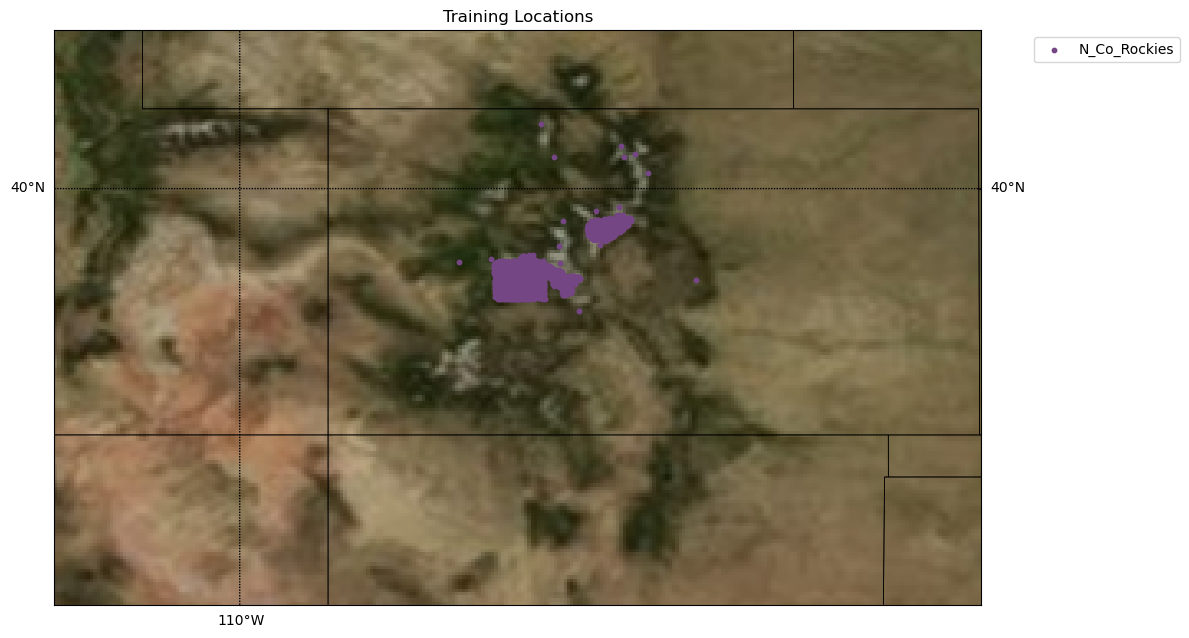

In [34]:
GeoPlot(RegionTrain)

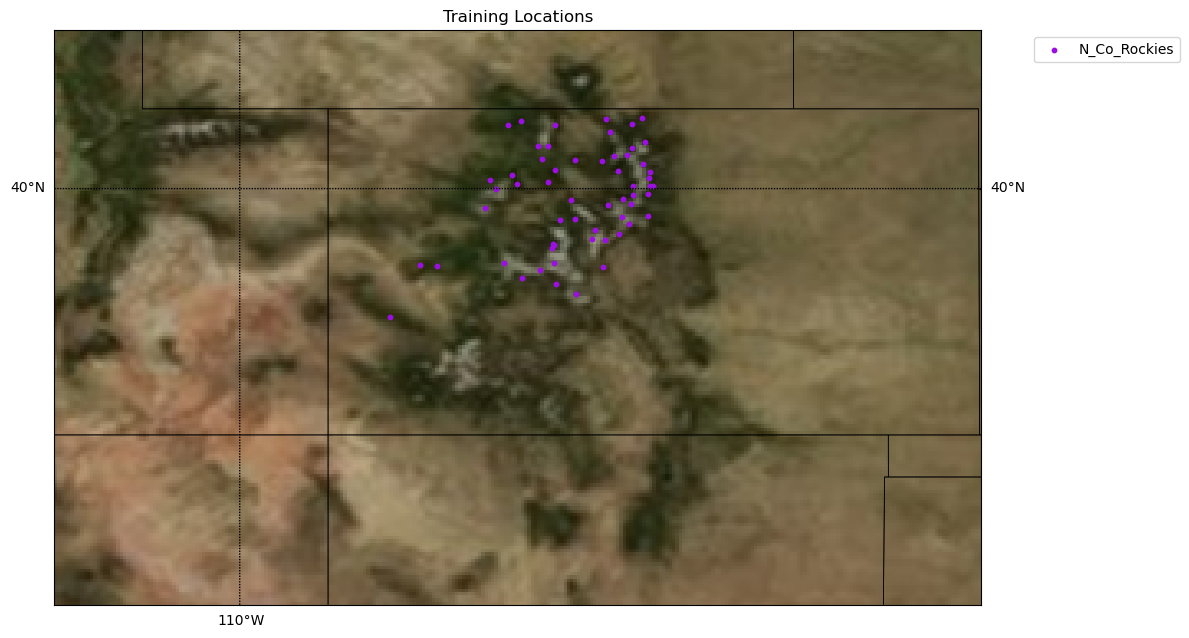

In [35]:
GeoPlot(RegionSnotel)

### Merge Geospatial data to SWE observations

In [36]:
#This function connects stationary geospatial information to observations
def Geo_to_Data(geodf, SWE, id):
    dfcols = ['Long','Lat','elevation_m','slope_deg','aspect','Date','SWE','Region']
    datadf = geodf.merge(SWE, how='inner', on=id)
    #datadf = datadf.set_index(id)
    datadf=datadf[dfcols]
    return datadf

#Create a temporal attribute, week_num(), that reflect the week id of the water year, beginning October 1st
def week_num(df):
        #week of water year
    weeklist = []

    for i in tqdm(range(0,len(df))):
        if df['Date'][i].month<11:
            y = df['Date'][i].year-1
        else:
            y = df['Date'][i].year
            
        WY_start = pd.to_datetime(str(y)+'-10-01')
        deltaday = df['Date'][i]-WY_start
        deltaweek = round(deltaday.days/7)
        weeklist.append(deltaweek)


    df['WYWeek'] = weeklist

In [37]:
#Merge Geospatial data to SWE observations

Snotel = Snotel.rename(columns = {'slope_Deg': 'slope_deg'})
Snotel.set_index('station_id', inplace = True)

Training = Geo_to_Data(TrainGeo_df, TrainSWE, 'cell_id')

# get snotel station id, region, slope, and aspect to merge with obervations
Snocol = ['Region','slope_deg','aspect']
Snotel = Snotel[Snocol]
GM_Snotel_train = Geo_to_Data(Snotel, GM_Train, 'station_id')

#Make Date in datetime dtype
Training['Date'] = pd.to_datetime(Training['Date'])
GM_Snotel_train['Date'] = pd.to_datetime(GM_Snotel_train['Date'])

#add week number to observations
week_num(Training)

#Save Geospatial data into SWE.h5 file
GM_Snotel_train.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'GM_Snotel_train', complevel = 9, complib = 'bzip2')
Training.to_hdf('Provided_Data/SWE_Rockies.h5', key = 'Training', complevel = 9, complib = 'bzip2')


100%|██████████| 8816/8816 [00:01<00:00, 7408.39it/s]


In [38]:
#Connect observations to regional data
#subset data by each region into dictionary
RegionTrain = {name: Training.loc[Training['Region'] == name] for name in Training.Region.unique()}
RegionSnotel_Train  = {name: GM_Snotel_train.loc[GM_Snotel_train['Region'] == name] for name in GM_Snotel_train.Region.unique()}


#save dictionaries as pkl
# create a binary pickle file 
RTrain = open("Provided_Data/RegionTrain.pkl","wb")
Rsnow_Train = open("Provided_Data/RegionSnotel_Train.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(RegionTrain,RTrain)
pickle.dump(RegionSnotel_Train,Rsnow_Train)

# close file
RTrain.close()
Rsnow_Train.close()

In [39]:
#load regionalized geospatial data
RTrain = open("Provided_Data/RegionTrain.pkl","rb")
Rsnow_Train = open("Provided_Data/RegionSnotel_Train.pkl","rb")

RegionTrain = pickle.load(RTrain)
RegionSnotel_Train = pickle.load(Rsnow_Train)

### Make the Northness Feature

 <img align = 'center' src="./Images/northness.JPG" alt = 'drawing' width = '300'/>

In [40]:
#This function defines northness: :  sine(Slope) * cosine(Aspect). this gives you a northness range of -1 to 1.
#Note you'll need to first convert to radians. 
#Some additional if else statements to get around sites with low obervations
def northness(df):    
    
    if len(df) == 8: #This removes single value observations, need to go over and remove these locations from training too
        #Determine northness for site
        #convert to radians
        df = pd.DataFrame(df).T
        
        df['aspect_rad'] = df['aspect']*0.0174533
        df['slope_rad'] = df['slope_deg']*0.0174533
        
        df['northness'] = -9999
        for i in range(0, len(df)):
            df['northness'].iloc[i] = math.sin(df['slope_rad'].iloc[i])*math.cos(df['aspect_rad'].iloc[i])

        #remove slope and aspects to clean df up
        df = df.drop(columns = ['aspect', 'slope_deg', 'aspect_rad', 'slope_rad', 'Region'])
        
        return df
        
    else:
         #convert to radians
        df['aspect_rad'] = df['aspect']*0.0174533
        df['slope_rad'] = df['slope_deg']*0.0174533
        
        df['northness'] = -9999
        for i in range(0, len(df)):
            df['northness'].iloc[i] = math.sin(df['slope_rad'].iloc[i])*math.cos(df['aspect_rad'].iloc[i])

        
         #remove slope and aspects to clean df up
        df = df.drop(columns = ['aspect', 'slope_deg', 'aspect_rad', 'slope_rad', 'Region'])
        
        return df

In [41]:
#make northness feature and delete regions, slope, aspect features for each training and testing cell
for i in tqdm(RegionTrain):
    RegionTrain[i] = northness(RegionTrain[i])
    
#Make dictionary in Regions dict for each region's dictionary of Snotel sites
Regions = list(RegionTrain.keys()).copy()

#Make northness for all Snotel observations
for i in tqdm(Regions):
    
    snotel = i+'_Snotel'
    RegionTrain[snotel] = {site: RegionSnotel_Train[i].loc[site] for site in RegionSnotel_Train[i].index.unique()}
    
    #get training and testing sites that are the same
    train = RegionTrain[snotel].keys()
    
    #make Northing metric
    for j in tqdm(train):
  #     
        RegionTrain[snotel][j] = northness(RegionTrain[snotel][j])
   
    #remove items we do not need
        RegionTrain[snotel][j] = RegionTrain[snotel][j].drop(columns = ['Long', 'Lat'])
    #make date index
        RegionTrain[snotel][j] = RegionTrain[snotel][j].set_index('Date')
        
    #rename columns to represent site info
        colnames = RegionTrain[snotel][j].columns
        print(colnames)
        sitecolnames = [x +'_'+ j for x in colnames]
        names = dict(zip(colnames, sitecolnames))
        RegionTrain[snotel][j] = RegionTrain[snotel][j].rename(columns = names)
    
    #Remove unused columns
    columns = list(RegionTrain[snotel].keys()).copy()
    for col in columns:
        if len(RegionTrain[snotel][col].columns) >4:
            del RegionTrain[snotel][col]

 12%|█▏        | 7/58 [00:00<00:01, 32.45it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 19%|█▉        | 11/58 [00:00<00:01, 31.86it/s]


Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')


 34%|███▍      | 20/58 [00:00<00:00, 38.10it/s]


Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')


 48%|████▊     | 28/58 [00:00<00:00, 34.74it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 62%|██████▏   | 36/58 [00:01<00:00, 32.71it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 76%|███████▌  | 44/58 [00:01<00:00, 32.96it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 90%|████████▉ | 52/58 [00:01<00:00, 32.63it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')


In [42]:

for i in tqdm(Regions):
    
    snotel = i+'_Snotel'
    RegionTrain[snotel] = {site: RegionSnotel_Train[i].loc[site] for site in RegionSnotel_Train[i].index.unique()}
    
    #get training and testing sites that are the same
    train = RegionTrain[snotel].keys()
    
    #make Northing metric
    for j in tqdm(train):
  #     
        RegionTrain[snotel][j] = northness(RegionTrain[snotel][j])
   
    #remove items we do not need
        RegionTrain[snotel][j] = RegionTrain[snotel][j].drop(columns = ['Long', 'Lat'])
    #make date index
        RegionTrain[snotel][j] = RegionTrain[snotel][j].set_index('Date')
        
    #rename columns to represent site info
        colnames = RegionTrain[snotel][j].columns
        print(colnames)
        sitecolnames = [x +'_'+ j for x in colnames]
        names = dict(zip(colnames, sitecolnames))
        RegionTrain[snotel][j] = RegionTrain[snotel][j].rename(columns = names)
    
    #Remove unused columns
    columns = list(RegionTrain[snotel].keys()).copy()
    for col in columns:
        if len(RegionTrain[snotel][col].columns) >4:
            del RegionTrain[snotel][col]

            
#make a df for training each region, 
for R in tqdm(Regions):
    snotels = R+'_Snotel'
    RegionTrain[R] = RegionTrain[R].reset_index()
    RegionTrain[R] = RegionTrain[R].set_index('Date')
      
    for S in RegionTrain[snotels]:
        RegionTrain[R]= pd.concat([RegionTrain[R], RegionTrain[snotels][S].reindex(RegionTrain[R].index)], axis=1)
    
    RegionTrain[R] = RegionTrain[R].fillna(-9999)
    
#save dictionaries as pkl
# create a binary pickle file 
#load regionalized geospatial data
RTrain = open("Provided_Data/Training.pkl","wb")


# write the python object (dict) to pickle file
pickle.dump(RegionTrain,RTrain)


# close file
RTrain.close()


  0%|          | 0/58 [00:00<?, ?it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



  7%|▋         | 4/58 [00:00<00:01, 33.06it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 14%|█▍        | 8/58 [00:00<00:01, 32.43it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 21%|██        | 12/58 [00:00<00:01, 31.88it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 28%|██▊       | 16/58 [00:00<00:01, 32.23it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 36%|███▌      | 21/58 [00:00<00:01, 36.42it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 43%|████▎     | 25/58 [00:00<00:00, 35.27it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 50%|█████     | 29/58 [00:00<00:00, 34.08it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 57%|█████▋    | 33/58 [00:00<00:00, 33.58it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 64%|██████▍   | 37/58 [00:01<00:00, 32.83it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 71%|███████   | 41/58 [00:01<00:00, 32.57it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 78%|███████▊  | 45/58 [00:01<00:00, 32.64it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



 84%|████████▍ | 49/58 [00:01<00:00, 32.44it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')


Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')


 91%|█████████▏| 53/58 [00:01<00:00, 32.15it/s]

Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')
Index(['elevation_m', 'SWE', 'northness'], dtype='object')



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Index(['elevation_m', 'SWE', 'northness'], dtype='object')


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


### Feature Engineering: Previous Week's SNOTEL SWE

We use in-situ station SWE observations as features, using the values observed from the current (Snotel/CDEC SWE) and the previous week (Previous Snotel/CDEC SWE) as inputs.

In [43]:
def Prev_SWE_Snotel_Dict(DF, region):
   # print(region)
    
    regionsnotel = region+'_Snotel'
    
    sites = DF[regionsnotel].keys()
    
    #week delta  
    weekdelta = pd.Timedelta(7, "d")
    
    for i in sites:
      #  print(i)
        prevSWE = 'Prev_SWE_' + i
        SWE = 'SWE_'+i
        
        DF[regionsnotel][i][prevSWE] = -9999.99
        
        #need to find the number of columns for ifelse
        dfcols = len(DF[regionsnotel][i].columns)
    

        #if only one observation need to fix
        if len(DF[regionsnotel][i]) == 1:
            DF[regionsnotel][i] = DF[regionsnotel][i].T

        for cell in range(1,len(DF[regionsnotel][i])):

            if DF[regionsnotel][i].index[cell] - DF[regionsnotel][i].index[cell-1] == weekdelta:     
                DF[regionsnotel][i][prevSWE][cell] = DF[regionsnotel][i][SWE][cell-1]
  

In [44]:
for i in tqdm(Regions):
    Prev_SWE_Snotel_Dict(RegionTrain, i)
    

100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


### Feature Engineering: Delta SNOTEL SWE


Using the observations from the current and previous week, we calculate the difference to capture the trend, either positive or negative, in SWE dynamics (i.e, melt or accumulation) with respect to each monitoring station ( $\Delta$ SWE). 

In [45]:
def Delta_SWE_Snotel_Dict(DF, region):
    # print(region)
    
    regionsnotel = region+'_Snotel'
    
    sites = DF[regionsnotel].keys()
    
    for i in sites:
      #  print(i)
        prevSWE = 'Prev_SWE_' + i
        SWE = 'SWE_'+i
        Delta_SWE = 'Delta_'+SWE
        
        DF[regionsnotel][i][Delta_SWE] = DF[regionsnotel][i][SWE] - DF[regionsnotel][i][prevSWE]
        DF[regionsnotel][i].loc[DF[regionsnotel][i][Delta_SWE]>150, Delta_SWE] =-9999.99
    
        

In [46]:
#Add Delta SWE feature
for i in tqdm(Regions):
    Delta_SWE_Snotel_Dict(RegionTrain, i)

100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


## Connect Snotel Observations to NASA ASO
Connect dataframe of NASA ASO with snotel observations

In [47]:
#make a df for training each region, 
#This DF comes last
for R in tqdm(Regions):
    snotels = R+'_Snotel'
    RegionTrain[R] = RegionTrain[R].reset_index()
    RegionTrain[R] = RegionTrain[R].set_index('Date')
    
    for S in RegionTrain[snotels]:
        RegionTrain[R]= pd.concat([RegionTrain[R], RegionTrain[snotels][S].reindex(RegionTrain[R].index)], axis=1)
    
    RegionTrain[R] = RegionTrain[R].fillna(-9999)

#Remove unnecessary features
for region in Regions:
    RegionTrain[region] = RegionTrain[region].drop( RegionTrain[region].filter(regex='elevation_m_').columns, axis=1)
    RegionTrain[region] = RegionTrain[region].drop( RegionTrain[region].filter(regex='northness_').columns, axis=1)
    RegionTrain[region] = RegionTrain[region].T.drop_duplicates().T
#Save near complete DataFrame    
RegionTrain['N_Co_Rockies'].to_hdf('Provided_Data/SWE_Rockies.h5', key = 'Delta_Prev_SWE_Training', complevel = 9, complib = 'bzip2')

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


## Target Site's Previous SWE 

Because of the serial correlation of snow accumulation and melt on the current timesteps SWE prediction, the model uses the SWE estimate of the previous week as a feature (Previous SWE).
For model training and testing, the Previous SWE input is from NASA ASO datasets.

In [48]:

def Prev_SWE(df, region, outfile):    
    print(region)
    
    df = df[region].reset_index()
    df = df.set_index('cell_id')
    
    #week delta  
    weekdelta = pd.Timedelta(7, "d")

    #set up column for previous weeks SWE
    df['prev_SWE'] = -9999.99
    
    #need to find the number of columns for ifelse
    dfcols = len(df.columns)
    
    #Run through each uniqe site/cell id to calculate previous weeks SWE and add to a new dataframe
    new_df = pd.DataFrame(columns = df.columns)
    
    #find unique sites
    sites = df.index.unique()
    
    #regiondata = dict(zip(sites, new_df))
   # print(regiondata.keys())
    
    for i in tqdm(sites):
        site = df.loc[i].copy()

        #if only one observation need to fix
        if site.shape == (dfcols,):# and len(site) < 162:
            #print(site, site.shape)
            site = site.to_frame().T

        for cell in range(1,len(site)):
            if site['Date'][cell] - site['Date'][cell-1] == weekdelta:     
                site['prev_SWE'][cell] = site['SWE'][cell-1]
        dflist = [new_df, site]
        new_df = pd.concat(dflist)
        #regiondata[i] = site
    new_df = new_df.fillna(-9999)
    
    #Put Prev_SWE next to SWE to confirm operations
    prev_SWE = new_df['prev_SWE'].copy()
    del new_df['prev_SWE']
    new_df.insert(loc = 5,
          column = 'prev_SWE',
          value = prev_SWE)
    
    
    new_df.to_hdf(outfile, key = region, complevel = 9, complib = 'bzip2')


In [49]:
#Choose a file path to save the final dataframe
file = 'Provided_Data/Final_Training_DF.h5'

#Run the previous SWE function and save the dataframe, you will now be ready to train the model.
for region in Regions:
    Prev_SWE(RegionTrain, region, file)

N_Co_Rockies


100%|██████████| 1757/1757 [00:21<00:00, 80.95it/s]


# Add model scaling?